# AI演習 第9回
### ディープラーニングによる自然言語処理 (3)

[実行環境]<br>
Python: 3.10.2<br>
TensorFlow: 2.14.0<br>

ランタイムのタイプは、GPUを指定するように注意してください。

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import tensorflow as tf

print(tf.__version__)

2.14.0


### RNN (Recurrent Neural Network)

*   再帰型のニューラルネットワークです。
*   自然言語処理などの分野で利用されます。
 * 文書分類、感情分析、機械翻訳、文章生成
* LSTM (Long short-term memory) や GRU (Gated recurrent units) などの応用モデルがあります。
<br>
<img src='https://drive.google.com/uc?export=view&id=1yPrN0u3icVHxT_OykvU4QqYgjcBUdRFj' width='70%'>




### RNNレイヤの詳細
+ 上図でで「*H*」の部分を、RNNレイヤと呼ぶことにします。
* RNNレイヤの入力xtと出力otの関係は、ot = tanh(ot-1 + xt Wx +b)のように計算されます。
* xtのWxは重み係数、bはバイアス値です。
* tanhは、双曲線正接関数という関数で、活性化関数として用いられています。

<br>
<img src='https://drive.google.com/uc?export=view&id=1oVMjqV76C-9dmaGROLXGnJTm6lIJftcY' width='65%'>

<br><br>
* RNNの構成は下図のようになります。ot-1にも重み係数Woをかけています。

<br>
<img src='https://drive.google.com/uc?export=view&id=11bUUhdqGXo_B5yOxU_JY1KRW0nq5txK0' width='65%'>

### RNNセルの基本計算

左端のセルを考えてみます。左端のセルは、otの入力がないため、

o2 = tanh(x1 Wx +b)

となります。

ここで、xとして単語ベクトルなどが入力されます。単語ベクトルの次元数を100、セル内部での次元数(隠れ層の次元数)を5として、上記の計算式をコーディングします。

In [ ]:
import numpy as np

wordvec_size = 100
hidden_size = 5

Wx = np.random.randn(wordvec_size, hidden_size)
b = np.zeros(hidden_size)
print(Wx.shape)
print(b.shape)

(100, 5)
(5,)


word2vecで学習される単語分散行列のベクトルを利用します。以前のコードを実行し、単語分散行列を生成します。

In [ ]:
!wget http://mattmahoney.net/dc/text8.zip

In [ ]:
!unzip text8.zip

In [ ]:
import logging
from gensim.models.word2vec import Word2Vec, Text8Corpus

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentences = Text8Corpus('text8')
model = Word2Vec(sentences, vector_size=100)

model.save('model.bin')

In [ ]:
model = Word2Vec.load('model.bin')

x = model.wv['dog']

先ほどの計算をしてみます。

In [ ]:
_o = np.dot(x, Wx) + b
print(_o)

[ -2.17544915   1.02002346  -4.9382929  -13.28689538   9.09094012]


次に活性化関数tanh()に入力します。

In [ ]:
o = np.tanh(_o)
print(o)

[-0.97453789  0.76987609 -0.99989728 -1.          0.99999997]


#### 確認例題 3-1
左端のRNNセルの計算をする関数RNN_cell0(x)を作成しましょう。

2つ目以降のRNNセルでは、左側のRNNセルの出力絵あるotも入力して計算します。2つめのRNNセルの計算式は下記のようになりまｓ。

o2 = tanh(o1 Wo + x1 Wx +b)



"I like dog"という文章について、1番目と2番目のそれぞれのRNNセルの計算をしてみます。

In [ ]:
x1 = model.wv['i']
x2 = model.wv['like']

先ほど同様に重み行列とバイアスを設定します。Woが新たに加わっています。

In [ ]:
wordvec_size = 100
hidden_size = 5

Wx = np.random.randn(wordvec_size, hidden_size)
Wo = np.random.randn(hidden_size, hidden_size)
b = np.zeros(hidden_size)

In [ ]:
o1 = np.dot(x1, Wx) + b
o2 = np.dot(o1, Wo) + np.dot(x1, Wx) + b

print(o1)
print(o2)

[-19.99489897  18.764167    16.10273764 -10.18887622 -10.09910226]
[  4.46060758 -20.90103787  28.6925767  -36.59006838   4.0405989 ]


#### 確認例題 3-2
3番目のRNNセルの計算をしましょう。

#### 確認例題 3-3
2番目のRNNセルを計算する関数RNN_cell(x, o)を作成しましょう。

### RNNによる文書分類
* 前回の1次元CNNの例題と同じように、IMDBデータセットを用いて、レビューのポジ・ネガ分類をします。

<br>
<img src='https://drive.google.com/uc?export=view&id=1sablSx9th6stHu8ML4oQnEWbIM2wp_On' width='60%'>


In [ ]:
# from keras.datasets import imdb
# from keras.preprocessing import sequence
import tensorflow as tf

max_words = 10000  # 単語数
max_len = 500  # 入力する単語列の長さ
embedding_dim = 128 # 単語埋め込み層の次元

print('データのロード中...')
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.imdb.load_data(num_words=max_words)
print(len(x_train), 'train 列 (sequence)')
print(len(x_test), 'test 列 (sequence)')

データのロード中...
25000 train 列 (sequence)
25000 test 列 (sequence)


In [ ]:
# パディング処理
x_train = tf.keras.utils.pad_sequences(x_train, maxlen=max_len)
x_test = tf.keras.utils.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [ ]:
print(len(x_train[0]))
print(x_train[0])

### RNNモデルの構築
* SimpleRNNを用いてRNNモデルを構築します。
* Embedding()は、単語のベクトル化をする単語の埋め込み層です。

In [ ]:
from keras.layers import SimpleRNN, Embedding, Dense
from keras.models import Sequential

embedding_dim=128
model_rnn=Sequential()
model_rnn.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_rnn.add(SimpleRNN(100))
model_rnn.add(Dense(1, activation='sigmoid'))
print(model_rnn.summary())

In [ ]:
model_rnn.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc'])

batch_size = 128
num_epochs = 3

history = model_rnn.fit(x_train, y_train,
              validation_split=0.2,
              batch_size=batch_size, epochs=num_epochs)

Epoch 1/3
157/157 [==============================] - 99s 620ms/step - loss: 0.6175 - acc: 0.6370 - val_loss: 0.4473 - val_acc: 0.8062
Epoch 2/3
157/157 [==============================] - 105s 669ms/step - loss: 0.4133 - acc: 0.8181 - val_loss: 0.4735 - val_acc: 0.7982
Epoch 3/3
157/157 [==============================] - 106s 677ms/step - loss: 0.3548 - acc: 0.8548 - val_loss: 0.5935 - val_acc: 0.6850


モデルの評価

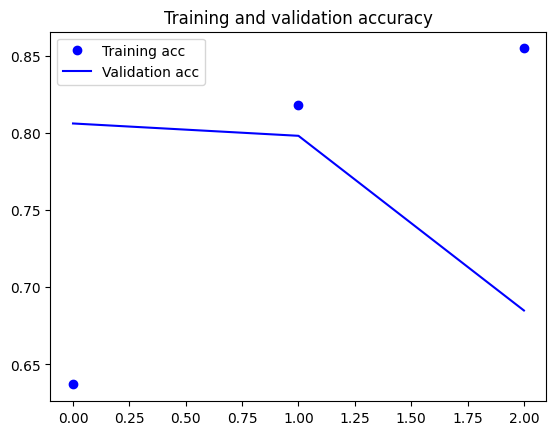

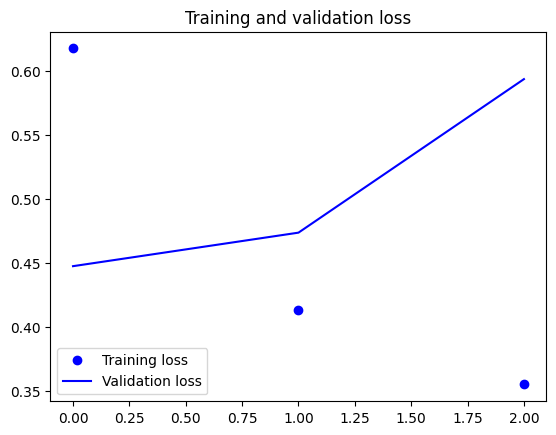

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
scores = model_rnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.6909199953079224


In [ ]:
pred0 = model_rnn.predict(x_test[0][np.newaxis])

print('予測値: ', pred0)
print('正解: ', y_test[0])

1/1 [==============================] - 0s 312ms/step
予測値:  [[0.15840095]]
正解:  0


#### 3-4 確認例題
* RNNモデルでepoch数を10に増やして実行してみましょう。分類精度や損失グラフも描画しましょう。(実行時間がかかるようならepoch数を少なくしても良いです。)
* x_test[0]、x_test[1]、x_test[2]を予測し、epoch数が少ない場合と比較して、結果に変化があったかを確認してみましょう。

### LSTM (Long short-term memory )
* RNNの一種のニューラルネットワークです。
* RNNでは、学習時に勾配消失が起きるため、うまく学習できないという問題があります。
* LSTMでは、次のLSTMレイヤへ記憶を伝達するための記憶セルを別途設けることで、学習時の勾配消失の問題を防ぎます。

<br>
<img src='https://drive.google.com/uc?export=view&id=1mVrLvxJMOAYTUocarZmyYocJV-b8bvNU' width='70%'>



### LSTMモデルの構築
* LSTMを用いてモデルを構築します。
* 先ほど作成したモデルで、SimpleRNNをLSTMに置き換えているだけで構築できます。

In [ ]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim=128
model_lstm=Sequential()
model_lstm.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(1, activation='sigmoid'))
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,371,701
Trainable params: 1,371,701
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_lstm.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc'])

batch_size = 128
num_epochs = 5

history = model_lstm.fit(x_train, y_train,
              validation_split=0.2,
              batch_size=batch_size, epochs=num_epochs)

Epoch 1/5
157/157 [==============================] - 223s 1s/step - loss: 0.4949 - acc: 0.7492 - val_loss: 0.3304 - val_acc: 0.8638
Epoch 2/5
157/157 [==============================] - 218s 1s/step - loss: 0.2711 - acc: 0.8936 - val_loss: 0.3189 - val_acc: 0.8692
Epoch 3/5
157/157 [==============================] - 217s 1s/step - loss: 0.2356 - acc: 0.9103 - val_loss: 0.3759 - val_acc: 0.8436
Epoch 4/5
157/157 [==============================] - 218s 1s/step - loss: 0.1584 - acc: 0.9435 - val_loss: 0.3989 - val_acc: 0.8714
Epoch 5/5
157/157 [==============================] - 218s 1s/step - loss: 0.1232 - acc: 0.9569 - val_loss: 0.4048 - val_acc: 0.8632


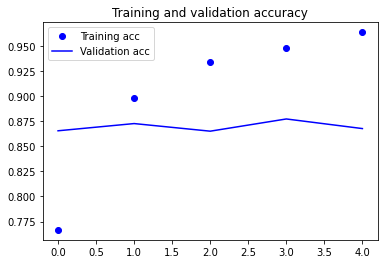

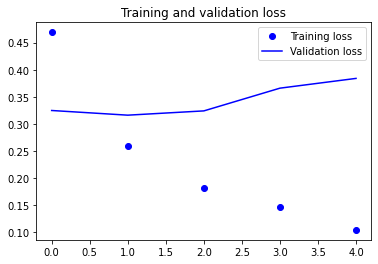

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
scores = model_lstm.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8551200032234192


#### 3-5 確認例題
* LSTMモデルでepoch数を10に増やして実行してみましょう。分類精度や損失グラフも描画しましょう。(実行時間がかかるようならepoch数を少なくしても良いです。)
* x_test[0]、x_test[1]、x_test[2]を予測し、epoch数が少ない場合と比較して、結果に変化があったかを確認してみましょう。

### GRU
* LSTMと同様に、RNNの一種のニューラルネットワークです。
* LSTMよりもパラメータ数を少なくし、計算コストを抑えたモデルになっています。
* LSTMのように記憶セルは用いませんが、学習時の勾配消失が起きないような構成となっています。

<br>
<img src='https://drive.google.com/uc?export=view&id=1xCFGPK8-KhbaGQYTPcKxN4xxHCO-C_Tp' width='90%'>


In [ ]:
from keras.layers import GRU
embedding_dim=128
model_gru=Sequential()
model_gru.add(Embedding(max_words, embedding_dim, input_length=max_len))
model_gru.add(GRU(100))
model_gru.add(Dense(1, activation='sigmoid'))
print(model_gru.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 gru (GRU)                   (None, 100)               69000     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,349,101
Trainable params: 1,349,101
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_gru.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc'])

batch_size = 128
num_epochs = 5

history = model_gru.fit(x_train, y_train,
              validation_split=0.2,
              batch_size=batch_size, epochs=num_epochs)

Epoch 1/5
157/157 [==============================] - 209s 1s/step - loss: 0.4621 - acc: 0.7656 - val_loss: 0.3351 - val_acc: 0.8586
Epoch 2/5
157/157 [==============================] - 201s 1s/step - loss: 0.2512 - acc: 0.8992 - val_loss: 0.3074 - val_acc: 0.8748
Epoch 3/5
157/157 [==============================] - 203s 1s/step - loss: 0.1701 - acc: 0.9392 - val_loss: 0.3156 - val_acc: 0.8740
Epoch 4/5
157/157 [==============================] - 203s 1s/step - loss: 0.1424 - acc: 0.9481 - val_loss: 0.3385 - val_acc: 0.8722
Epoch 5/5
157/157 [==============================] - 203s 1s/step - loss: 0.0971 - acc: 0.9657 - val_loss: 0.4190 - val_acc: 0.8428


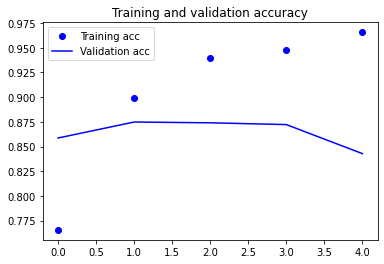

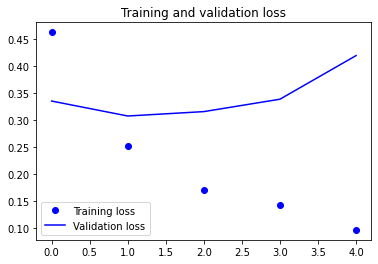

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
scores = model_gru.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8332800269126892


#### 3-6 確認例題
* GRUモデルでepoch数を10に増やして実行してみましょう。分類精度や損失グラフも描画しましょう。(実行時間がかかるようならepoch数を少なくしても良いです。)
* x_test[0]、x_test[1]、x_test[2]を予測し、epoch数が少ない場合と比較して、結果に変化があったかを確認してみましょう。

#### 3-7 確認例題
* 一次元CNN、SimpleRNN、LSTM、GRUの4つのモデルについて、分類精度を比較し、考察してみましょう。
* さらに、モデルのパラメータ数にも着目して比較し、考察してみましょう。


### 参考文献
* https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms
* Keras公式Webサイト, https://keras.io/examples/